# AA2 Práctica 3

In [1]:
# Cargamos librería necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error



## 1. Carga y examen de datos

Obtenemos el conjunto de datos para entrenar el modelo

In [2]:
# Descargar los datos
!wget "https://udcgal.sharepoint.com/:u:/s/GCEDAprendizajeAutomaticoII/EW-oyZUCNkBMvy80CvRjlnABDl5jxrGj1JyXG3C2vr2xAA?e=61EuOe&download=1" -O data.json

# Cargar los datos en un DataFrame
data = pd.read_json('data.json')

--2024-12-18 15:50:08--  https://udcgal.sharepoint.com/:u:/s/GCEDAprendizajeAutomaticoII/EW-oyZUCNkBMvy80CvRjlnABDl5jxrGj1JyXG3C2vr2xAA?e=61EuOe&download=1
Resolving udcgal.sharepoint.com (udcgal.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to udcgal.sharepoint.com (udcgal.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://udcgal.sharepoint.com/sites/GCEDAprendizajeAutomaticoII/_layouts/15/download.aspx?UniqueId=95c9a86f36024c40bf2f340af4639670 [following]
--2024-12-18 15:50:09--  https://udcgal.sharepoint.com/sites/GCEDAprendizajeAutomaticoII/_layouts/15/download.aspx?UniqueId=95c9a86f36024c40bf2f340af4639670
Reusing existing connection to udcgal.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 9312908 (8.9M) [application/json]
Saving to: ‘data.json’

data.json           100%[===================>]   8.88M  7.66MB/s    in 1.2s    

2024-12-18 15:50:10 (7.66 M

Hacemos un análisis superficial del conjunto de datos. Imprimimos las primeras filas, información general y estadísticas descriptivas.

In [3]:
# Mostramos el tamaño del dataset
print("Tamaño del dataset:")
print(data.shape)
print()

# Mostrar las primeras filas
print("Primeras filas del dataset:")
print(data.head())

Tamaño del dataset:
(24970, 11)

Primeras filas del dataset:
    timestamp inicial  precio inicio  precio mas alto  precio mas bajo  \
0 2020-01-03 08:00:00         1.1154           1.1200           1.1154   
1 2020-01-03 09:00:00         1.1182           1.1182           1.1151   
2 2020-01-03 10:00:00         1.1151           1.1172           1.1151   
3 2020-01-03 11:00:00         1.1136           1.1151           1.1136   
4 2020-01-03 12:00:00         1.1126           1.1133           1.1126   

   precio fin   volumen         timestamp final  volumen en cuotas  \
0      1.1182  37309.48 2020-01-03 08:59:59.999       41775.464275   
1      1.1151   2132.61 2020-01-03 09:59:59.999        2384.431292   
2      1.1151   1950.83 2020-01-03 10:59:59.999        2175.391533   
3      1.1141    310.53 2020-01-03 11:59:59.999         346.107438   
4      1.1133    394.52 2020-01-03 12:59:59.999         439.130428   

   numero de compras  volumen de dolares  volumen de euros  
0           

In [4]:
print("\nInformación del dataset:")
print(data.dtypes)


Información del dataset:
timestamp inicial     datetime64[ns]
precio inicio                float64
precio mas alto              float64
precio mas bajo              float64
precio fin                   float64
volumen                      float64
timestamp final       datetime64[ns]
volumen en cuotas            float64
numero de compras              int64
volumen de dolares           float64
volumen de euros             float64
dtype: object


Examen preliminar de los datos, buscando valores nulos, valores no númericos y datos atípicos.

In [5]:
# Revisar valores nulos
print("\nRevisar valores nulos:")
print(data.isnull().sum())

# Verificar valores no numéricos en 'precio fin'
no_numericos = data[~data['precio fin'].apply(lambda x: isinstance(x, (int, float)))]
print(f"\nRegistros con valores no numéricos en 'precio fin': {len(no_numericos)}")

# Verificar valores no numéricos en 'precio mas bajo'
no_numericos = data[~data['precio mas bajo'].apply(lambda x: isinstance(x, (int, float)))]
print(f"\nRegistros con valores no numéricos en 'precio mas bajo': {len(no_numericos)}")

# Identificar registros erróneos
invalid_records = data[data['precio fin'] <= 0]
print(f"\nRegistros con precios fin negativos o nulos: {len(invalid_records)}")

invalid_records = data[data['precio mas bajo'] <= 0]
print(f"\nRegistros con precios mínimos negativos o nulos: {len(invalid_records)}")



Revisar valores nulos:
timestamp inicial     0
precio inicio         0
precio mas alto       0
precio mas bajo       0
precio fin            0
volumen               0
timestamp final       0
volumen en cuotas     0
numero de compras     0
volumen de dolares    0
volumen de euros      0
dtype: int64

Registros con valores no numéricos en 'precio fin': 0

Registros con valores no numéricos en 'precio mas bajo': 0

Registros con precios fin negativos o nulos: 0

Registros con precios mínimos negativos o nulos: 0


In [6]:
# Comprobamos si hay datos faltantes, horas sin datos

# Convertir la columna 'fecha' a datetime
data['timestamp inicial'] = pd.to_datetime(data['timestamp inicial'])
data['timestamp final'] = pd.to_datetime(data['timestamp final'])

# Ordenar los datos por fecha
data = data.sort_values(by='timestamp inicial')

# Calcular la diferencia en horas entre cada registro
diferencias = data['timestamp inicial'].diff().dropna()

# Identificar las diferencias mayores a 1 hora
faltantes = diferencias[diferencias > pd.Timedelta(hours=1)]
# Almacenamos la posicion de los faltantes
faltantes = faltantes.index
# Convertimos faltantes en un array
faltantes = faltantes.to_numpy()

print("\nHoras sin datos:")
print(faltantes)


Horas sin datos:
[  882  1131  1460  2699  4233  7954  8465  8545  9698 10247 11326 11447
 14081 15210]


In [7]:
#df_train.iloc[(rows_with_mismatch[1]-1): (rows_with_mismatch[1] + 3)]
# Imprimimos los datos faltantes el registro anterior y posterior por orden de fecha
for i in range(len(faltantes)):
    print(f"\nDatos faltantes en el registro {faltantes[i]}:")
    print(data.iloc[(faltantes[i]-1): (faltantes[i] + 1)])


Datos faltantes en el registro 882:
      timestamp inicial  precio inicio  precio mas alto  precio mas bajo  \
881 2020-02-09 01:00:00         1.0952           1.0952           1.0893   
882 2020-02-09 03:00:00         1.0951           1.0953           1.0918   

     precio fin  volumen         timestamp final  volumen en cuotas  \
881      1.0893  3278.32 2020-02-09 01:59:59.999        3588.509303   
882      1.0953  5928.94 2020-02-09 03:59:59.999        6492.664648   

     numero de compras  volumen de dolares  volumen de euros  
881                 26             2895.65       3171.019672  
882                 23             5784.45       6334.910466  

Datos faltantes en el registro 1131:
       timestamp inicial  precio inicio  precio mas alto  precio mas bajo  \
1130 2020-02-19 11:00:00         1.0799           1.0799           1.0775   
1131 2020-02-19 17:00:00         1.0799           1.0799           1.0762   

      precio fin  volumen         timestamp final  volumen en

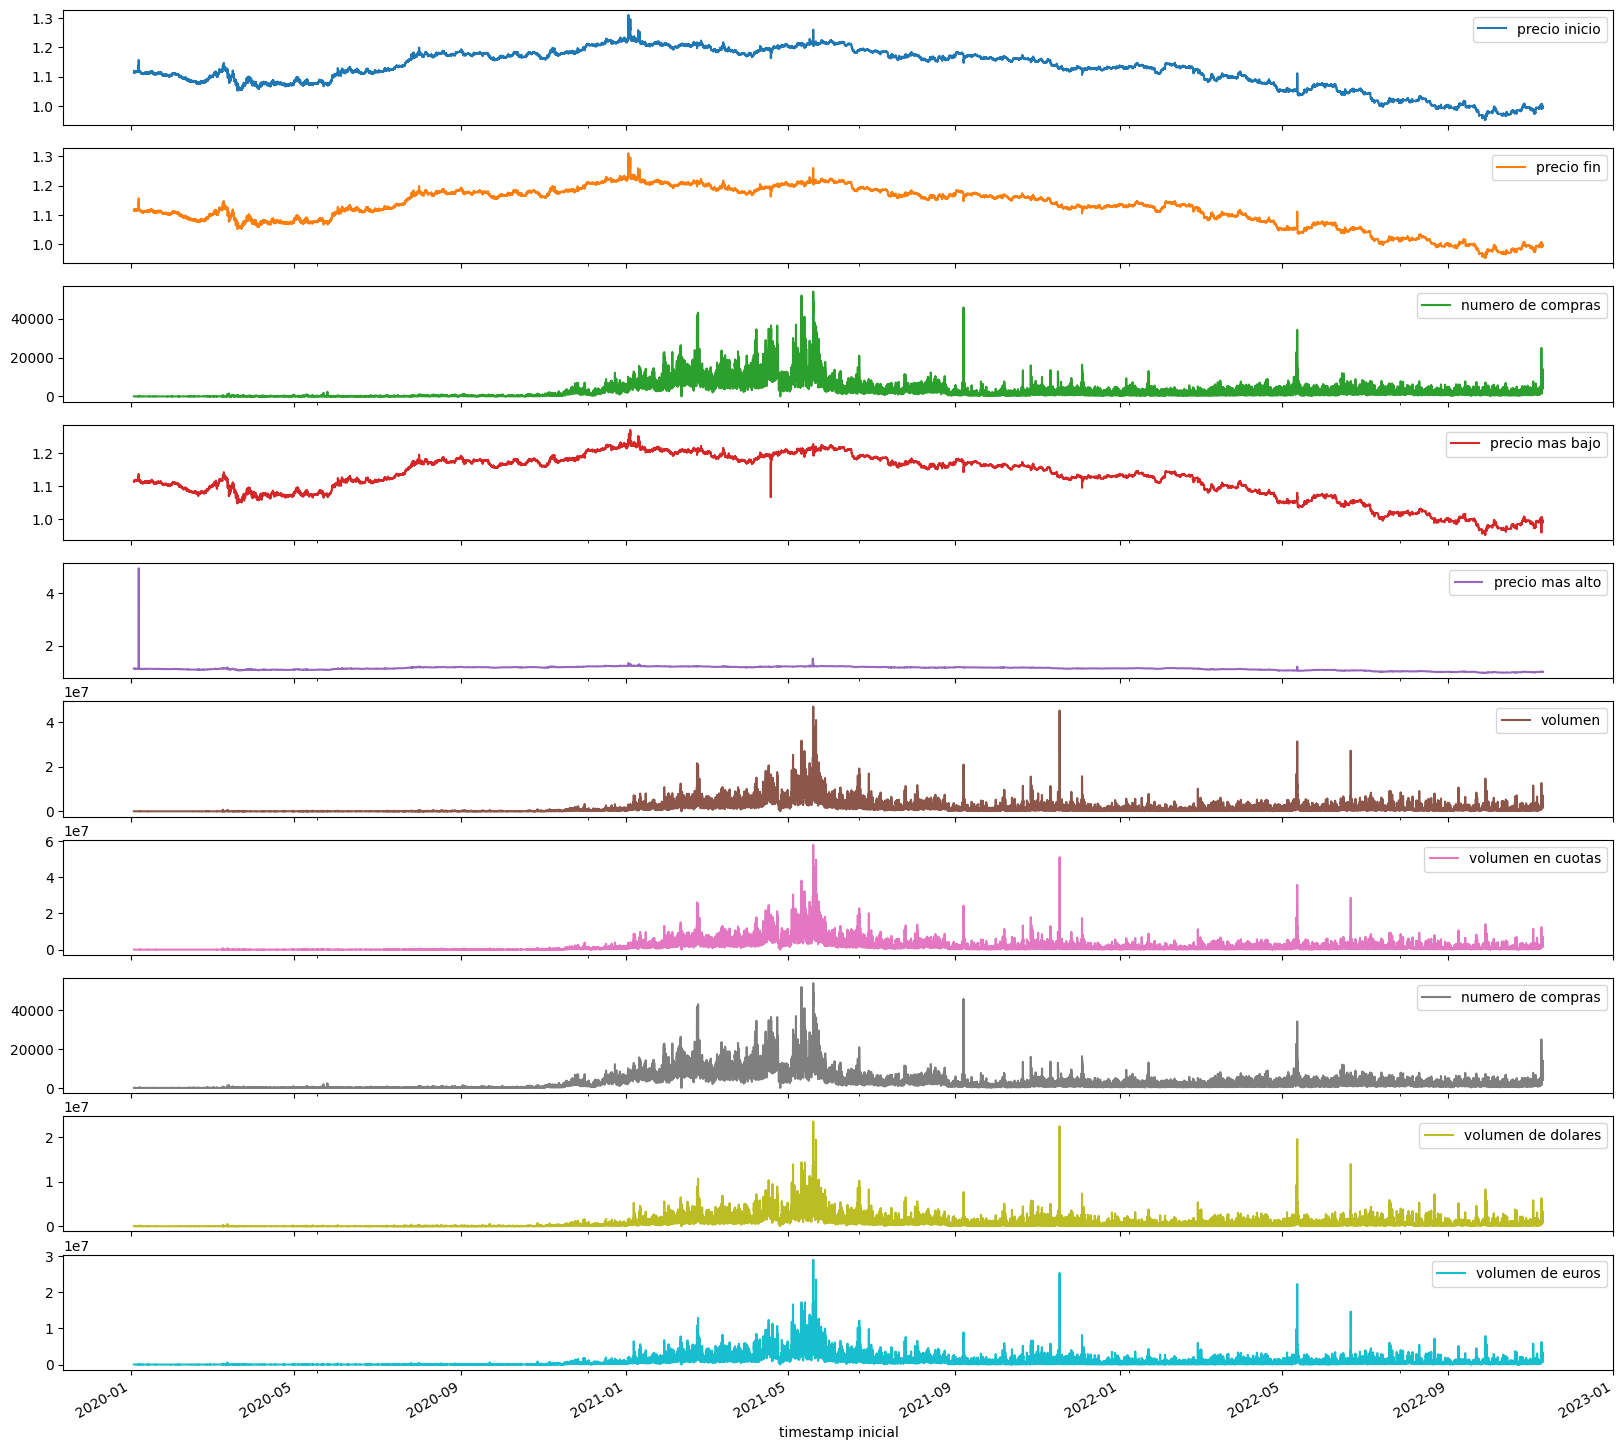

In [8]:
plot_cols = ['precio inicio', 'precio fin', 'numero de compras', 'precio mas bajo', 'precio mas alto', 'volumen', 'volumen en cuotas', 'numero de compras', 'volumen de dolares', 'volumen de euros']
plot_features = data[plot_cols]
plot_features.index = data['timestamp inicial']
_ = plot_features.plot(subplots=True, figsize=(20, 20))

# plot_features = data[plot_cols][:480]
# plot_features.index = data['timestamp inicial'][:480]
# _ = plot_features.plot(subplots=True)

In [9]:
# Parece que hay datos erróneos. Vamos a localizarlos y eliminarlos

# Enseñamos el valor máximo de precio mas alto
print(f"Precio mas alto máximo: {data['precio mas alto'].max()}")
outlier = data['precio mas alto'].idxmax()
print(f"Registro con precio mas alto atípico: {outlier}")

# Vamos a hacer lo mismo de otra forma
data = data[data['precio mas alto'] != data['precio mas alto'].max()]

# Añadimos el valor eliminado a el indice de faltantes
faltantes = np.append(faltantes, outlier)

# Ordenamos los indices
faltantes = np.sort(faltantes)
print(f"\nFaltantes: {faltantes}")


Precio mas alto máximo: 4.95
Registro con precio mas alto atípico: 86

Faltantes: [   86   882  1131  1460  2699  4233  7954  8465  8545  9698 10247 11326
 11447 14081 15210]


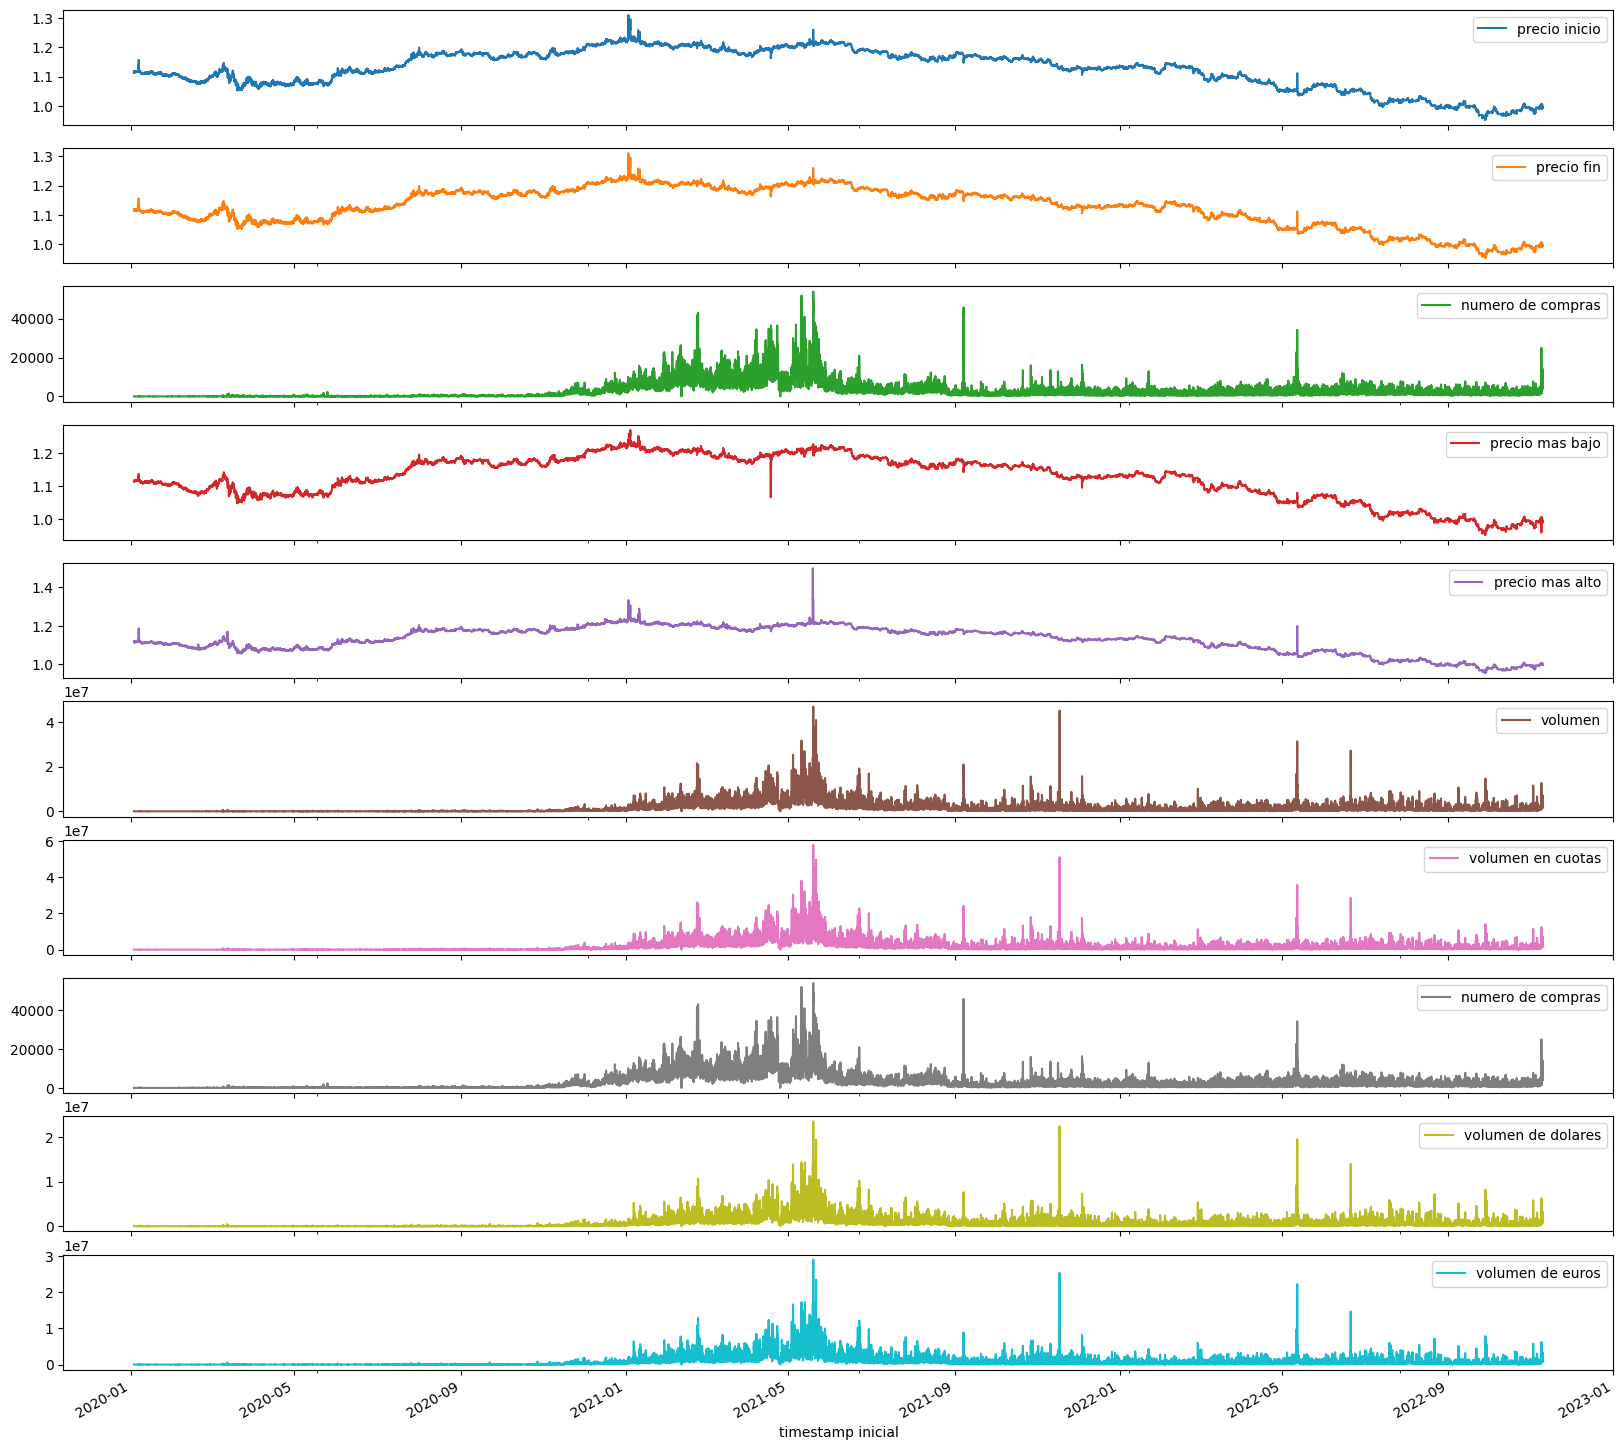

In [10]:
plot_cols = ['precio inicio', 'precio fin', 'numero de compras', 'precio mas bajo', 'precio mas alto', 'volumen', 'volumen en cuotas', 'numero de compras', 'volumen de dolares', 'volumen de euros']
plot_features = data[plot_cols]
plot_features.index = data['timestamp inicial']
_ = plot_features.plot(subplots=True, figsize=(20, 20))

In [11]:
data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp inicial,24969,2021-06-07 10:22:49.698426112,2020-01-03 08:00:00,2020-09-19 23:00:00,2021-06-07 14:00:00,2022-02-22 22:00:00,2022-11-10 00:00:00,NaN
precio inicio,24969.0,1.126497,0.9536,1.08,1.133,1.1788,1.3098,0.066951
precio mas alto,24969.0,1.127644,0.9554,1.082,1.134,1.1799,1.5,0.067045
precio mas bajo,24969.0,1.12533,0.9535,1.078,1.132,1.1777,1.2695,0.066926
precio fin,24969.0,1.126459,0.9536,1.08,1.133,1.1787,1.3098,0.066936
volumen,24969.0,1588199.853359,0.0,74416.58,791359.4,2069777.7,46948429.81,2435407.757103
timestamp final,24969,2021-06-07 11:22:49.329060352,2020-01-03 08:59:59.999000,2020-09-19 23:59:59.999000064,2021-06-07 14:59:59.999000064,2022-02-22 22:59:59.999000064,2022-11-10 00:59:59.999000,NaN
volumen en cuotas,24969.0,1831478.614056,0.0,85609.2765,872408.682156,2302634.0791,57843832.806441,2898266.068515
numero de compras,24969.0,3249.760343,0.0,298.0,2046.0,4215.0,53917.0,4291.643158
volumen de dolares,24969.0,741325.517814,0.0,31935.12,335942.9,950998.5,23544369.72,1189493.224344


Realizamos la partición de los datos en entrenamiento y test

In [12]:
# Los datos desde 01/09/2022 00:00:00 en adelante se podrán utilizar como conjunto de test
data_train = data[data['timestamp inicial'] < '2022-09-01 00:00:00']
data_test = data[data['timestamp inicial'] >= '2022-09-01 00:00:00']

print(f"Registros en el conjunto de entrenamiento: {len(data_train)}")
print(f"Registros en el conjunto de test: {len(data_test)}")

Registros en el conjunto de entrenamiento: 23288
Registros en el conjunto de test: 1681


## 2. Preprocesado de datos

Estandarizamos los datos que lo necesitan y convertimos las fechas a un formato adecuado.

In [13]:
# Convertir la columna 'timestamp inicial' y 'timestamp final' a tipo datetime
# date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_inicial = pd.to_datetime(data_train.pop('timestamp inicial'), format='%Y-%m-%d %H:%M:%S')
timestamp_final = pd.to_datetime(data_train.pop('timestamp final'), format='%Y-%m-%d %H:%M:%S')

# Convertimos a segundos
timestamp_inicial_s = timestamp_inicial.map(pd.Timestamp.timestamp)
timestamp_final_s = timestamp_final.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

# Extrae, para cada fecha, el seno y el coseno, y añádelos al dataframe
data_train['Day ini sin'] = np.sin(timestamp_inicial_s * (2 * np.pi / day))
data_train['Day ini cos'] = np.cos(timestamp_inicial_s * (2 * np.pi / day))
data_train['Year ini sin'] = np.sin(timestamp_inicial_s * (2 * np.pi / year))
data_train['Year ini cos'] = np.cos(timestamp_inicial_s * (2 * np.pi / year))
data_train['Day fin sin'] = np.sin(timestamp_final_s * (2 * np.pi / day))
data_train['Day fin cos'] = np.cos(timestamp_final_s * (2 * np.pi / day))
data_train['Year fin sin'] = np.sin(timestamp_final_s * (2 * np.pi / year))
data_train['Year fin cos'] = np.cos(timestamp_final_s * (2 * np.pi / year))


# Convertir la columna 'timestamp inicial' y 'timestamp final' a tipo datetime
timestamp_inicial = pd.to_datetime(data_test.pop('timestamp inicial'), format='%Y-%m-%d %H:%M:%S')
timestamp_final = pd.to_datetime(data_test.pop('timestamp final'), format='%Y-%m-%d %H:%M:%S')

# Convertimos a segundos
timestamp_inicial_s = timestamp_inicial.map(pd.Timestamp.timestamp)
timestamp_final_s = timestamp_final.map(pd.Timestamp.timestamp)

# Extrae, para cada fecha, el seno y el coseno, y añádelos al dataframe
data_test['Day ini sin'] = np.sin(timestamp_inicial_s * (2 * np.pi / day))
data_test['Day ini cos'] = np.cos(timestamp_inicial_s * (2 * np.pi / day))
data_test['Year ini sin'] = np.sin(timestamp_inicial_s * (2 * np.pi / year))
data_test['Year ini cos'] = np.cos(timestamp_inicial_s * (2 * np.pi / year))
data_test['Day fin sin'] = np.sin(timestamp_final_s * (2 * np.pi / day))
data_test['Day fin cos'] = np.cos(timestamp_final_s * (2 * np.pi / day))
data_test['Year fin sin'] = np.sin(timestamp_final_s * (2 * np.pi / year))
data_test['Year fin cos'] = np.cos(timestamp_final_s * (2 * np.pi / year))


<ipython-input-13-7cc4939f8793>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Day ini sin'] = np.sin(timestamp_inicial_s * (2 * np.pi / day))
<ipython-input-13-7cc4939f8793>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['Day ini cos'] = np.cos(timestamp_inicial_s * (2 * np.pi / day))
<ipython-input-13-7cc4939f8793>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [14]:
# Calculamos la media y la desviación estándar
train_mean = data_train.mean()
train_std = data_train.std()

# Normalizamos los datos
data_train = (data_train - train_mean) / train_std
data_test = (data_test - train_mean) / train_std

Observamos si están balanceados y en la misma escala

<ipython-input-15-46f628960ee0>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(data_train.keys(), rotation=90)


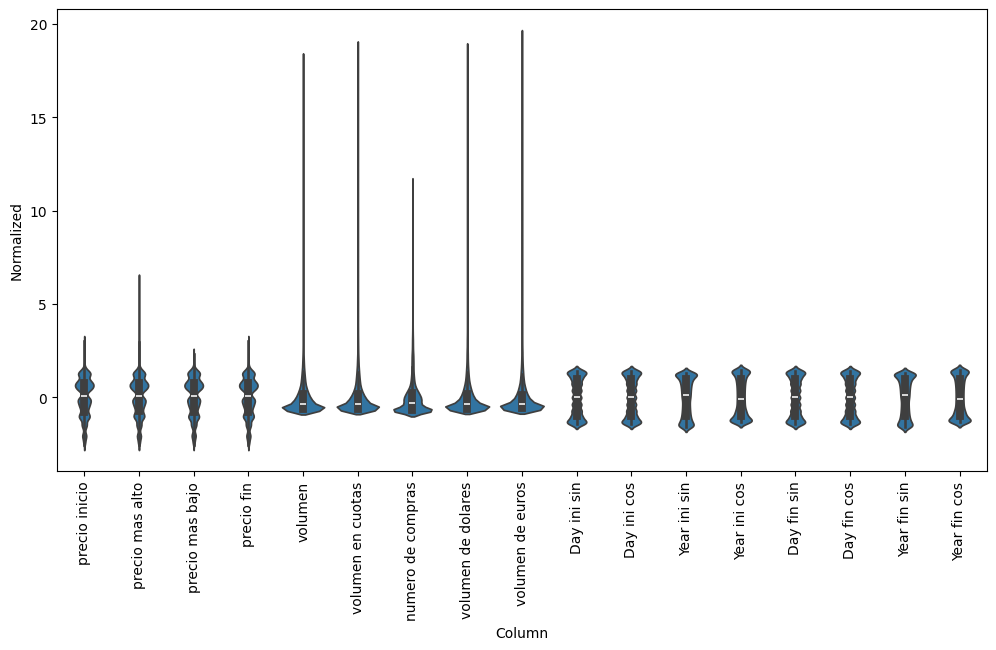

In [15]:
df_std = data_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(data_train.keys(), rotation=90)

Tranformamos los conjuntos a numpy

In [16]:
X_train = data_train.to_numpy()
X_test = data_test.to_numpy()

Ventana de datos

In [17]:
# Definimos la función sliding_window como en el lab9

def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data) - input_width - label_width - offset + 1):
        _x = data[i:i+input_width]
        _y = labels[i+input_width+offset:i+input_width+label_width+offset]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)

    if len(x.shape) == 2:
        x = x[:,:,np.newaxis]

    if len(y.shape) == 2:
        y = y[:,:,np.newaxis]

    return x, y

- **input_width** = 24: Número de datos anteriores (Es variable,  se prueban distintos valores)
- **offset** = 6: Busca predecir el precio de la acción 6 horas después de los datos de entrada
- **label_width** = 1: Solo predecimos un dato

In [18]:
input_width = 24
label_width = 1
offset = 6
target_label = 'precio fin'

x_train, y_train = sliding_window(X_train, X_train[:, data_train.columns.get_loc(target_label)], input_width, label_width, offset)
x_test, y_test = sliding_window(X_test, X_test[:, data_test.columns.get_loc(target_label)], input_width, label_width, offset)

print('x_train shape :', x_train.shape)
print('y_train shape :', y_train.shape)
print('x_test shape :', x_test.shape)
print('y_test shape :', y_test.shape)

x_train shape : (23258, 24, 17)
y_train shape : (23258, 1, 1)
x_test shape : (1651, 24, 17)
y_test shape : (1651, 1, 1)


Debemos eliminar las ventanas que contengan valores faltantes

In [19]:
# Eliminamos las ventanas en las que esten incluidos los datos que pueden dar problemas (indice faltantes)

# Borramos las ventas que contengan los datos problematicos
def borrar_ventanas_con_faltantes(x, y, faltantes: pd.Index):
    a_borrar = []
    for i in range(len(x)):
        for falta in faltantes:
            if falta in range(i, i + input_width):
                a_borrar.append(i)
                break
    x = np.delete(x, a_borrar, axis=0)
    y = np.delete(y, a_borrar, axis=0)
    return x, y

# Sabemos que solo hay faltantes en el conjunto de entrenamiento
x_train, y_train = borrar_ventanas_con_faltantes(x_train, y_train, faltantes)

print('x_train shape :', x_train.shape)
print('y_train shape :', y_train.shape)


x_train shape : (22898, 24, 17)
y_train shape : (22898, 1, 1)


## 3. Elección de los modelos

Arquitectura Dense

In [20]:
modelo_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_width, X_train.shape[-1])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(units=label_width)
])

modelo_dense.summary()

modelo_dense.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 408)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          52,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,721 (245.00 KB)

 Trainable params: 62,721 (245.00 KB)

 Non-trainable params: 0 (0.00 B)

Arquitectura LSTM

In [21]:
modelo_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(input_width, X_train.shape[-1]), return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=label_width)
])

modelo_lstm.summary()

modelo_lstm.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 128)             │          74,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 24, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,609 (533.63 KB)

 Trainable params: 136,609 (533.63 KB)

 Non-trainable params: 0 (0.00 B)

Modelo GRU

In [22]:
modelo_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=(input_width, X_train.shape[-1]), return_sequences=True),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.Dense(units=label_width)
])

modelo_gru.summary()

modelo_gru.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 24, 128)             │          56,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 24, 64)              │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,137 (402.88 KB)

 Trainable params: 103,137 (402.88 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar los modelos

In [23]:
# Entrenamos los 3 modelos
MAX_EPOCHS = 20
batch_size = 32

history_dense = modelo_dense.fit(x_train, y_train, epochs=MAX_EPOCHS, batch_size=batch_size, verbose=1)

history_lstm = modelo_lstm.fit(x_train, y_train, epochs=MAX_EPOCHS, batch_size=batch_size, verbose=1)

history_gru = modelo_gru.fit(x_train, y_train, epochs=MAX_EPOCHS, batch_size=batch_size, verbose=1)


Epoch 1/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0383 - mae: 0.1236
Epoch 2/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090 - mae: 0.0673
Epoch 3/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0065 - mae: 0.0585
Epoch 4/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064 - mae: 0.0570
Epoch 5/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0056 - mae: 0.0545
Epoch 6/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0053 - mae: 0.0529
Epoch 7/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - mae: 0.0527
Epoch 8/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0052 - mae: 0.0527
Epoch 9/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - mae: 0.0494
Epoch 10/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0046 - mae: 0.0485
Epoch 11/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0049 - mae: 0.0506
Epoch 12/20
716/716 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - mae: 0.0491
Epoch 13/20
716/716 ━━━━━

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


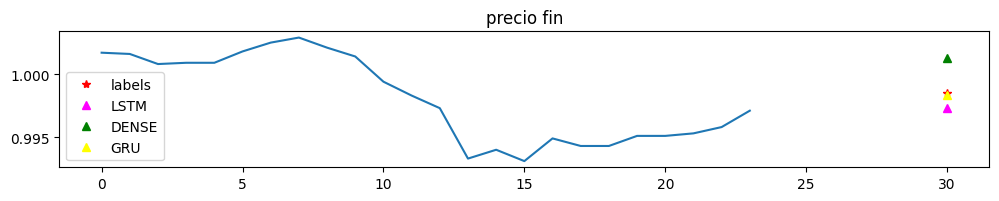

In [32]:
def plot_prediction(feed_data, expected_result, model_results, target_label, offset=1, index=1, names =('LSTM','DENSE','GRU') ):
    f_data_x = np.arange(feed_data.shape[1])
    e_data_x = np.arange(expected_result.shape[1]) + offset
    plt.plot(f_data_x, feed_data[index])
    plt.plot(e_data_x, expected_result[index], '*r', label='labels')
    colors = ('magenta', 'green', 'yellow')
    for i, model_result in enumerate(model_results):
        plt.plot(e_data_x, model_result[index], '^', label=f'{names[i]}', color=colors[i])
    plt.legend()
    plt.title(target_label)
    plt.show()


# Predecimos el resultado de test con los 3 modelos
y_pred_dense = modelo_dense.predict(x_test)
y_pred_lstm = modelo_lstm.predict(x_test)
y_pred_gru = modelo_gru.predict(x_test)

target_index = data_test.columns.get_loc(target_label)

# Mostramos las predicciones
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plot_prediction(x_test[:, :, target_index] * train_std[target_label] + train_mean[target_label], y_test * train_std[target_label] + train_mean[target_label], (y_pred_lstm * train_std[target_label] + train_mean[target_label], y_pred_dense * train_std[target_label] + train_mean[target_label], y_pred_gru * train_std[target_label] + train_mean[target_label]), target_label, input_width + offset, names=('LSTM', 'DENSE', 'GRU'))

In [33]:
# Baseline 1: Predicción del último valor de entrada
baseline1 = x_test[:, -1, target_index]
mse_baseline1 = mean_squared_error(np.squeeze(y_test, axis=2), baseline1)
print(f"Baseline 1 MSE: {mse_baseline1}")

Baseline 1 MSE: 0.004086836409266579


In [34]:
# Baseline 2: Predicción de la media de los valores de entrada
baseline2 = np.mean(x_test[:,:, target_index], axis=1)
mse_baseline2 = mean_squared_error(np.squeeze(y_test, axis=2), baseline2)
print(f"Baseline 2 MSE: {mse_baseline2}")

Baseline 2 MSE: 0.00790104753656178
